<a href="https://colab.research.google.com/github/genki3ng/ADS-Training/blob/main/EDA_How_to_handle_null_value.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Missing data is probably the most common problem in data analysis and there are different methods in literature to deal with missing data. We will cover some of the basic methods to deal with missing data here. 

1. Complete Case Analysis - Completely remove the missing data. 
2. Mean/Median/Mode based imputation.
3. Model based imputation (Regression Models and KNN based models)
4. Multiple Imputation - where you create multiple imputated datasets, analyze them separately and pool the findings.

In [ ]:
####Read the dataset

###Call the relevant libraries
!pip install -q umap-learn
!curl -L -O https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv

import os
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

import seaborn as sns; 
import umap 
import matplotlib.colors as mcolors
from importlib import reload #for dev
import matplotlib.pyplot as plt
import matplotlib 

%matplotlib inline

     |████████████████████████████████| 81kB 5.9MB/s 
     |████████████████████████████████| 1.2MB 14.2MB/s 
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  947k  100  947k    0     0  3223k      0 --:--:-- --:--:-- --:--:-- 3223k


In [ ]:
df = pd.read_csv("Telco-Customer-Churn.csv")
df = df.replace(r'^\s$', np.nan, regex=True) ###replace empty cells with na
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
###introduce missing values in couple more columns at random
null_cols = ['gender', 'tenure', 'Contract']
for col in df[null_cols]:
    df.loc[df.sample(frac=0.05).index, col] = np.nan

In [ ]:
###check where the missing values are 
print(df.columns[df.isna().any()].tolist()) 

['gender', 'tenure', 'Contract', 'TotalCharges']


In [ ]:
###Count total number of missing values
print(df.isnull().sum())

customerID            0
gender              352
SeniorCitizen         0
Partner               0
Dependents            0
tenure              352
PhoneService          0
MultipleLines         0
InternetService       0
OnlineSecurity        0
OnlineBackup          0
DeviceProtection      0
TechSupport           0
StreamingTV           0
StreamingMovies       0
Contract            352
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges         11
Churn                 0
dtype: int64


# Complete Case Method
Remove all the missing data. This method should only be used when you have very small portion of missing data in your dataset. Small portion is relative and can vary from case to case -- but the general rule of thumb is 5%. 

You can achieve this two ways:
1. Removing all the missing data
2. Remove data based on each variable.

In [ ]:
### Removing all the missing data
df_remove_all = df.dropna(axis=0)
print("Original Data: ", df.shape, "\n")
print("Removed Data: ", df_remove_all.shape, "\n")

Original Data:  (7043, 21) 

Removed Data:  (6030, 21) 



In [ ]:
###Sanity Check
df_remove_all.isnull().sum() ###Print missing data for each variable

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [ ]:
###Removing it by each variable. In this case we only give you one variable specific example

#Remove rows that have null in Gender column
# creating bool series True for null values 
bool_series = pd.notnull(df["gender"]) 
    
# filtering data by selecting data only with Gender = Not Null
df_rm_null_gender = df[bool_series] 

###Look at the shape of the data
print("Original Data: ", df.shape, "\n")
print("Removing Gender NULL data: ", df_rm_null_gender.shape, "\n")

# Check if there is still null in Gender
df_rm_null_gender.isnull().sum()

Original Data:  (7043, 21) 

Removing Gender NULL data:  (6691, 21) 



customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure              336
PhoneService          0
MultipleLines         0
InternetService       0
OnlineSecurity        0
OnlineBackup          0
DeviceProtection      0
TechSupport           0
StreamingTV           0
StreamingMovies       0
Contract            333
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges         11
Churn                 0
dtype: int64

# Impute the missing values of numerical variable
Impute with mean/median/mode or zero. We can use `fillna()` or  `replace()`

Mean or median imputation is most commonly done for continous variables. Mean is a preferred way if we have normal or nearly normal distribution of the variables. 

If you are unsure of the distribution or know that there is skewed distribution for the variable that is to be imputed - then we recommend that you use median imputation.

We will show few example of the imputation method here. 

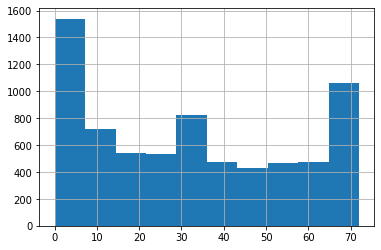

In [ ]:
###Look at the distribution of tenure variable -- check the skew
df2 = df.copy(deep=True)
df2.tenure.hist()

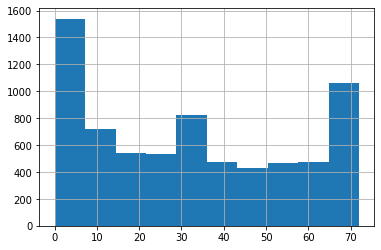

In [ ]:
# Impute with mean, you can replace mean() with median() or mode()
df2["tenure"] = df2["tenure"].fillna(df2["tenure"].mean())
df2.tenure.hist()

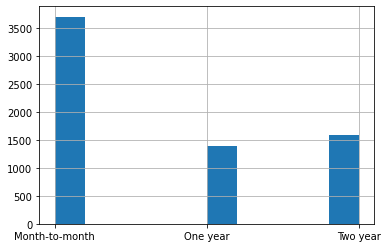

In [ ]:
df2.Contract.hist()

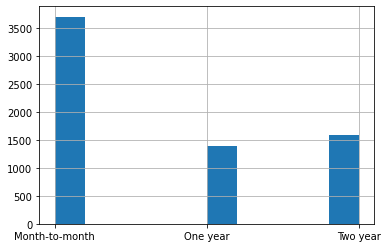

In [ ]:
# Impute with mode for contract 
df2["Contract"] = df2["Contract"].fillna(df2["Contract"].mode())
df2.Contract.hist()

#3 Impute the missing values of categorical variable

Impute with either mode or 'unknown'.

Mode imputation refers to imputing with the most common value - and this is recommend imputation for categorical data. 

In [ ]:
print(df2.gender.value_counts())

Male      3369
Female    3322
Name: gender, dtype: int64


In [ ]:
# Impute with 'unknown' --- just an example here
df2["gender"] = df2["gender"].replace(np.nan,'unknown')
print(df2.gender.value_counts())

Male       3369
Female     3322
unknown     352
Name: gender, dtype: int64


# Model based imputation:
We are using missingpy library here to execute model based imputation. The models can vary from KNN, linear regression or random forest based imputation. We show one example of KNN based imputation here.

In [ ]:
!pip install missingpy

     |████████████████████████████████| 51kB 4.2MB/s 


In [ ]:
df2.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [ ]:
from missingpy import KNNImputer ### You can also use fancyimpute to do the same operation
###JUst selecting numeric columns to prevent creating dummy variables 
relevant_cols = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
X_model_impute = df[relevant_cols]
print(X_model_impute.columns[X_model_impute.isna().any()].tolist(), "\n\n\n") 
X_model_impute.head()

['TotalCharges'] 





,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
0,0,1.000,29.850,29.85
1,0,34.000,56.950,1889.5
2,0,2.000,53.850,108.15
3,0,45.000,42.300,1840.75
4,0,2.000,70.700,151.65


In [ ]:
imputer = KNNImputer(n_neighbors=2, weights="uniform")
X_model_impute = imputer.fit_transform(X_model_impute)
X_model_impute = pd.DataFrame(X_model_impute)
print(X_model_impute.columns[X_model_impute.isna().any()].tolist(), "\n\n\n") 
X_model_impute.head()

[] 





/usr/local/lib/python3.7/dist-packages/missingpy/pairwise_external.py:135: FutureWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  warn_on_dtype=warn_on_dtype, estimator=estimator)
/usr/local/lib/python3.7/dist-packages/missingpy/pairwise_external.py:138: FutureWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  warn_on_dtype=warn_on_dtype, estimator=estimator)
/usr/local/lib/python3.7/dist-packages/missingpy/utils.py:124: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


,0,1,2,3
0,0.000,1.000,29.850,29.850
1,0.000,34.000,56.950,1889.500
2,0.000,2.000,53.850,108.150
3,0.000,45.000,42.300,1840.750
4,0.000,2.000,70.700,151.650


# Multiple Imputation (MI)

Multiple imputation as the name implies imputes missing data through an iterative series of predictive models. In each iteration, each specified variable in the dataset is imputed using the other variables in the dataset. These iterations should be run until it appears that convergence has been met.

One of the most common MI technique is Multiple Imputation by Chained Equations (MICE). We will show the implementation of this method using `fancyimpute` library.

In [ ]:
from fancyimpute import IterativeImputer
X_mice_impute = df[relevant_cols]
print(X_mice_impute.columns[X_mice_impute.isna().any()].tolist(), "\n") 
X_mice_impute.head()

['TotalCharges'] 



,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
0,0,1.000,29.850,29.85
1,0,34.000,56.950,1889.5
2,0,2.000,53.850,108.15
3,0,45.000,42.300,1840.75
4,0,2.000,70.700,151.65


In [ ]:
mice_imputer = IterativeImputer()
X_mice_impute = mice_imputer.fit_transform(X_mice_impute)
X_mice_impute = pd.DataFrame(X_mice_impute)
print(X_mice_impute.columns[X_mice_impute.isna().any()].tolist(), "\n") 
X_mice_impute.head()

[] 



,0,1,2,3
0,0.000,1.000,29.850,29.850
1,0.000,34.000,56.950,1889.500
2,0.000,2.000,53.850,108.150
3,0.000,45.000,42.300,1840.750
4,0.000,2.000,70.700,151.650
